## Glassdoor : Predicting Job Slot Product Retention

In [1]:
# Data Cleaning
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# importing copy module 
import copy 

# Removing Warnings
import warnings
warnings.filterwarnings('ignore')

# for ML:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Reading the data
df_slot = pd.read_excel("DS_Intern_Assignment_-_2020.xlsx", sheet_name="Ex 1 - Slot Performance Data")
df_loc = pd.read_excel("DS_Intern_Assignment_-_2020.xlsx", sheet_name="Ex 2 - Location Data")

In [3]:
print("Dimension for job slot data:", df_slot.shape)
print("Dimension for location data:", df_loc.shape)

df_slot.head(5)

Dimension for job slot data: (37757, 12)
Dimension for location data: (11458, 4)


,Employer_ID,City_ID,Contract_ID,StartDate,EndDate,Renewal_Flag,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings
0,4.277920e+06,9767,2423796,2017-10-30 00:00:00.000,2017-11-30 23:59:59.000,1,15,995,215,255,15484.40,25
1,2.372987e+06,8585,2074128,2017-06-29 00:00:00.000,2017-07-29 23:59:59.000,0,50,1495,55,70,1719.30,50
2,1.142693e+06,6665,1924740,2017-05-02 00:00:00.000,2017-06-02 23:59:59.000,0,15,495,45,95,1195.75,20
3,1.353893e+06,5165,1942512,2017-05-09 00:00:00.000,2017-06-06 23:59:59.000,0,15,995,155,175,1197.35,20
4,9.224267e+05,3882,1380984,2016-09-19 15:14:21.707,2016-10-20 15:14:20.707,1,15,745,150,185,8889.70,20


In [4]:
df_loc.head(5)

,City_ID,City_Name,State_ID,State_Name
0,1,Rockford,OH,Ohio
1,2,Sedgewickville,MO,Missouri
2,3,Whitehouse,OH,Ohio
3,4,Victor,IA,Iowa
4,5,Pacific Junction,IA,Iowa


In [5]:
# Joining both the dataframes by "City_ID"
df_master = df_slot.merge(df_loc[["City_ID","City_Name","State_Name"]], on = "City_ID")
df_master["Employer_ID"] = df_master["Employer_ID"].astype(int)
# df_master["EndDate"] = df_master["EndDate"].dt.date
# df_master["StartDate"] = df_master["StartDate"].dt.date

print("Dimension for master data:", df_master.shape)
df_master.head(5)

Dimension for master data: (37757, 14)


,Employer_ID,City_ID,Contract_ID,StartDate,EndDate,Renewal_Flag,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,City_Name,State_Name
0,4277920,9767,2423796,2017-10-30,2017-11-30 23:59:59,1,15,995,215,255,15484.4,25,Kaser,New York
1,1747093,9767,2123400,2017-07-19,2017-08-18 23:59:59,1,15,1745,20,145,3131.2,0,Kaser,New York
2,2833226,9767,1895796,2017-04-22,2017-05-21 23:59:59,1,15,495,80,120,726.2,20,Kaser,New York
3,1827813,9767,1283400,2016-08-03,2016-09-02 23:59:59,1,15,495,20,45,1852.1,0,Kaser,New York
4,2234880,9767,2021376,2017-06-12,2017-07-11 23:59:59,1,15,745,85,95,2339.5,0,Kaser,New York


In [6]:
def add_features(var):
    df_master[var+"_year"] = df_master[var+"Date"].dt.year
    df_master[var+"_month"] = df_master[var+"Date"].dt.month
    df_master[var+"_day"] = df_master[var+"Date"].dt.day
    return df_master

In [7]:
df_master2 = add_features("Start")
df_master2 = add_features("End")

In [8]:
df_master2.head()

,Employer_ID,City_ID,Contract_ID,StartDate,EndDate,Renewal_Flag,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,City_Name,State_Name,Start_year,Start_month,Start_day,End_year,End_month,End_day
0,4277920,9767,2423796,2017-10-30,2017-11-30 23:59:59,1,15,995,215,255,15484.4,25,Kaser,New York,2017,10,30,2017,11,30
1,1747093,9767,2123400,2017-07-19,2017-08-18 23:59:59,1,15,1745,20,145,3131.2,0,Kaser,New York,2017,7,19,2017,8,18
2,2833226,9767,1895796,2017-04-22,2017-05-21 23:59:59,1,15,495,80,120,726.2,20,Kaser,New York,2017,4,22,2017,5,21
3,1827813,9767,1283400,2016-08-03,2016-09-02 23:59:59,1,15,495,20,45,1852.1,0,Kaser,New York,2016,8,3,2016,9,2
4,2234880,9767,2021376,2017-06-12,2017-07-11 23:59:59,1,15,745,85,95,2339.5,0,Kaser,New York,2017,6,12,2017,7,11


### PART A:  Write SQL queries to answer the following questions

[ https://github.com/birajparikh16/Glassdoor-Predicting-Job-Slot-Product-Retention/blob/master/mysql_queries.txt ]

Please refer the above link for mysql queries.

### PART B:  Metric Design and Exploratory Data Analysis

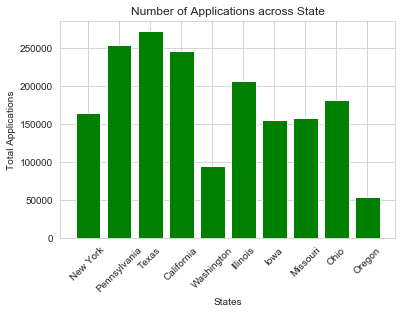

In [9]:
# Which state has the highest number of applications ? ===> Texas
states_apps = {}
for i in range(len(df_master2["State_Name"])):
    if(df_master2["State_Name"][i] not in states_apps):
        states_apps[df_master2["State_Name"][i]] = df_master2["Applications"][i]
    else:
        states_apps[df_master2["State_Name"][i]] += df_master2["Applications"][i]

plt.bar(range(len(states_apps)), list(states_apps.values()), align='center', facecolor = "Green")
plt.xticks(range(len(states_apps)), list(states_apps.keys()))
plt.title("Number of Applications across State")
plt.ylabel("Total Applications")
plt.xlabel("States")
plt.xticks(rotation=45);

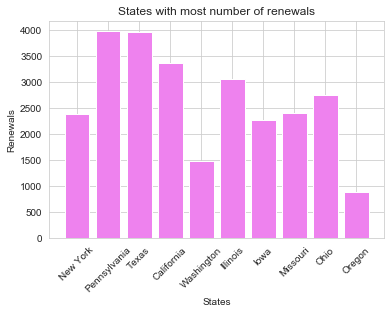

In [10]:
# Which state has the most number of renewals ? ===> pennsylvania
states_ren = {}
for i in range(len(df_master2["State_Name"])):
    if(df_master2["State_Name"][i] not in states_ren):
        states_ren[df_master2["State_Name"][i]] = df_master2["Renewal_Flag"][i]
    else:
        states_ren[df_master2["State_Name"][i]] += df_master2["Renewal_Flag"][i]

plt.bar(range(len(states_ren)), list(states_ren.values()), align='center', facecolor = "violet")
plt.xticks(range(len(states_ren)), list(states_ren.keys()))
plt.title("States with most number of renewals")
plt.ylabel("Renewals")
plt.xlabel("States")
plt.xticks(rotation=45);

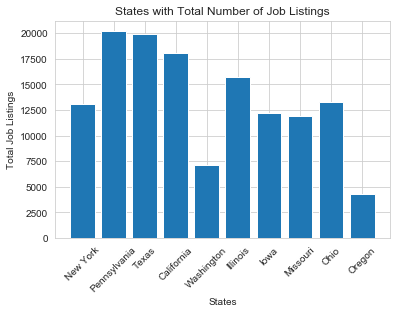

In [11]:
# Which state has the highest number of Job listings ? ===> pennsylvania
states_jobs = {}
for i in range(len(df_master2["State_Name"])):
    if(df_master2["State_Name"][i] not in states_jobs):
        states_jobs[df_master2["State_Name"][i]] = df_master2["Job_Listings"][i]
    else:
        states_jobs[df_master2["State_Name"][i]] += df_master2["Job_Listings"][i]

plt.bar(range(len(states_jobs)), list(states_jobs.values()), align='center')
plt.xticks(range(len(states_jobs)), list(states_jobs.keys()))
plt.title("States with Total Number of Job Listings")
plt.ylabel("Total Job Listings")
plt.xlabel("States")
plt.xticks(rotation=45);

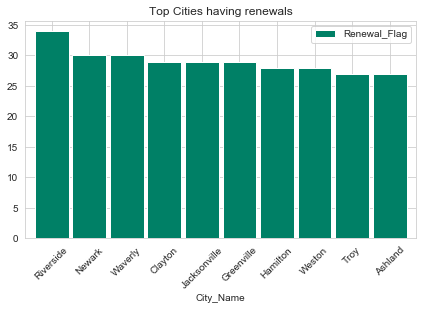

In [12]:
# Which city has the most number of renewals ? ===> riverside
city_ren = df_master2.groupby("City_Name").agg({"Renewal_Flag" : 'count'}).sort_values(by='Renewal_Flag',ascending=False).reset_index()[:10]
# print(city_ren)
city_ren.set_index('City_Name',inplace=True)
city_ren.plot.bar(width=0.9,cmap='summer')
fig=plt.gcf()
fig.set_size_inches(7,4)
plt.title('Top Cities having renewals')
plt.xticks(rotation=45)
plt.show();

In [13]:
# How many employers has multiple renewals ?
emp_ren = df_master2.groupby("Employer_ID").agg({"Renewal_Flag" : sum}).sort_values(by='Renewal_Flag',ascending=False)
emp_ren = emp_ren[emp_ren.Renewal_Flag > 1]
print("The number of employers having multiple renewals: ", len(emp_ren))

The number of employers having multiple renewals:  4684


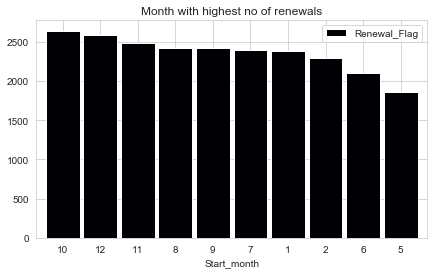

In [14]:
# Which month has the highest number of renewals ? ===> 10 (October)
mon_ren = df_master2.groupby("Start_month").agg({"Renewal_Flag" : sum}).sort_values(by='Renewal_Flag',ascending=False).reset_index()[:10]
mon_ren.set_index('Start_month',inplace=True)
mon_ren.plot.bar(width=0.9,cmap='magma')
fig=plt.gcf()
fig.set_size_inches(7,4)
plt.title('Month with highest no of renewals')
plt.xticks(rotation=360)
plt.show();

In [15]:
df_master2["Job_Slots"].value_counts()

15    35705
50     2052
Name: Job_Slots, dtype: int64

In [16]:
df_master2["Employer_ID"].nunique()

11458

In [17]:
df_master2.groupby(["State_Name"]).agg({"Applications": 'sum', "Job_Listings": 'sum'}).reset_index()

,State_Name,Applications,Job_Listings
0,California,246005,18075
1,Illinois,207325,15750
2,Iowa,155525,12190
3,Missouri,158670,11890
4,New York,164580,13115
5,Ohio,181640,13325
6,Oregon,53975,4305
7,Pennsylvania,253865,20220
8,Texas,272710,19905
9,Washington,95255,7175


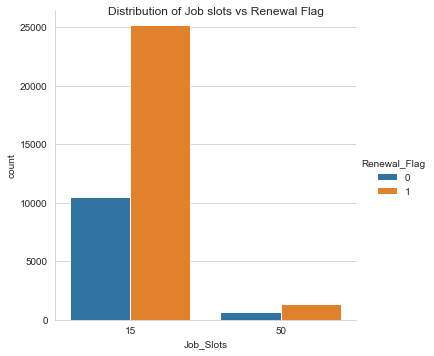

In [18]:
# Distribution of **job slots** vs **Renewal Flag** ?
ax = sns.factorplot('Job_Slots',data=df_master2,kind='count',hue="Renewal_Flag")
ax.fig.suptitle('Distribution of Job slots vs Renewal Flag');

As seen from the above Bar graph that the variable "Job Slot" does have an effect on the response variable "Renewal Flag".
But intuitively, selecting job slot 15 doesn't mean that the employer is going to renew the subscription. 
Most start-up companies prefer job slot 15 as they require only few team members thus it is seen that distribution of job slot 15 is higher than job slot 50.

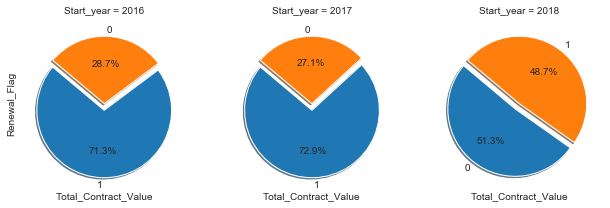

In [19]:
# Distribution of Total contract value vs Renewal Flag

df = df_master2.groupby(["Start_year","Renewal_Flag"]).agg({"Total_Contract_Value" : sum})\
              .sort_values(by='Total_Contract_Value',ascending=False).reset_index()
#df.head()

def pie(v, l, color=None):
    plt.pie(v, labels=l.values, explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
    
explode = (0.1, 0)
g = sns.FacetGrid(df, col="Start_year")
g.map(pie, "Total_Contract_Value", "Renewal_Flag")
#g.fig.suptitle('Distribution of Total_Contract_Value vs Renewal Flag');


plt.show();

From the above pie chart, it is clear that the variable "Total_contract_value" is important to consider for analysis of the use-case. The distribution of subscription renewal is much more in the years 2016 and 2017 whereas in the 2018 year the distribution of subscription renewal is almost equal may be because of any other factor like low economy growth in the country.

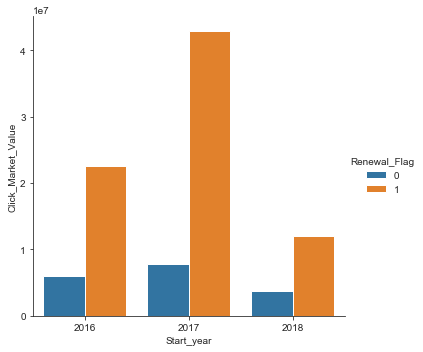

In [20]:
# Distribution of Click_Market_Value vs Renewal Flag
df2 = df_master2.groupby(["Start_year","Renewal_Flag"]).agg({"Click_Market_Value" : sum})\
              .sort_values(by='Click_Market_Value',ascending=False).reset_index()

with sns.axes_style(style='ticks'):
    g = sns.factorplot("Start_year", "Click_Market_Value", "Renewal_Flag", data=df2, kind="bar")
    g.set_axis_labels("Start_year", "Click_Market_Value");

The variable "Click Market Value" too seem important. As the click market value increase the chances of subscription renewal also increase. So, it make sense to include the "Click Market Value" variable in the machine learning model. 

In [21]:
df_master3 = copy.deepcopy(df_master2)

In [22]:
df_master3.drop(columns = ["Employer_ID", "Contract_ID", "StartDate", "EndDate", "City_Name", "State_Name"],inplace=True)

In [23]:
df_master3.head()

,City_ID,Renewal_Flag,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,Start_year,Start_month,Start_day,End_year,End_month,End_day
0,9767,1,15,995,215,255,15484.4,25,2017,10,30,2017,11,30
1,9767,1,15,1745,20,145,3131.2,0,2017,7,19,2017,8,18
2,9767,1,15,495,80,120,726.2,20,2017,4,22,2017,5,21
3,9767,1,15,495,20,45,1852.1,0,2016,8,3,2016,9,2
4,9767,1,15,745,85,95,2339.5,0,2017,6,12,2017,7,11


#### Plotting the graph of feature importance

In [24]:
# Separate features and predicted value
X = df_master3.drop(["Renewal_Flag"], axis=1)
y = df_master3["Renewal_Flag"]

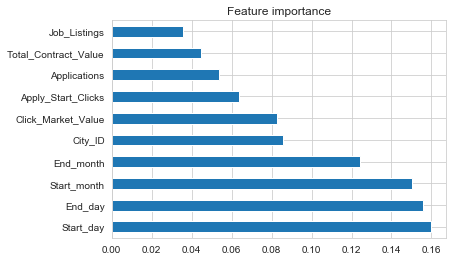

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
# using inbuilt class feature_importances of tree based classifiers
# print(model.feature_importances_) 
# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Feature importance")
plt.show()

Using the built-in feature of ExtraTreesClassifier model to show the important features. As seen from the above graph the variable **Click Market Value** and **Total contract Value** are important to use as independent variables to predict the likelihood of renewal subscription.

### PART C:  Retention Analysis

In [26]:
# Divide data into training and validation sets:
# 70 % for training, 30 % for validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [27]:
X_train.shape, y_train.shape

((26429, 13), (26429,))

In [28]:
X_test.shape, y_test.shape

((11328, 13), (11328,))

In [29]:
X_train.head()

,City_ID,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,Start_year,Start_month,Start_day,End_year,End_month,End_day
18075,6601,50,2995,310,355,4157.20,0,2017,4,20,2017,5,10
19001,6334,15,495,0,0,7.60,0,2017,10,11,2017,11,10
23267,5571,15,1245,0,10,1374.25,15,2017,11,10,2017,12,9
18205,1410,15,495,5,10,447.75,0,2017,1,16,2017,1,17
14628,6926,15,1495,5,10,1607.40,0,2018,1,14,2018,2,13


In [30]:
rf = RandomForestClassifier(random_state = 22)

# Preprocessing of training data, fit model:
rf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions:
preds = rf.predict(X_test)

# Evaluate the model:
score = accuracy_score(y_test, preds)
print("\n")
print("accuracy_score:{} % ".format(round(score,2)))



accuracy_score:0.85 % 


Thus, model gives an acccuracy of 85% which seems pretty reasonable.
The other factors which can be investigated is to include the other variables like "State_Name" by applying onehotencoding which might increase the accuracy of the model.
I would recommend that in order to increase the renewals, I would modify the bidding algorithm to focus on adding more jobs applications which generate more click market value and ultimately geneate total dollar value of the apply start clicks delivered to clients. 